In [1]:
import os
os.chdir('..')

In [2]:
import torch
from omegaconf import DictConfig
from omegaconf import OmegaConf
import monai
import matplotlib.pyplot as plt

from tl_2d3d.data.make_dataset import make_dataloaders
from tl_2d3d.utils import get_device, set_seed
from tl_2d3d.models.model import make_model
import medpy.metric as metric

from monai.transforms import BatchInverseTransform
from monai.transforms.utils import allow_missing_keys_mode

## Load model

In [22]:
model_path = '/work3/s204163/3dimaging_finalproject/weights/notpretrained2d_1312/notpretrained2d_final.pt'
config = OmegaConf.load('tl_2d3d/conf/config.yaml')
set_seed(seed = config.hyperparameters.seed)
device = get_device()

# Load test dataloader
_, _, test_dataloader, test_transforms = make_dataloaders(config, use_dataset_a=config.data.use_dataset_a)

# Load model
config.model.path_to_weights = model_path
print(config.model.path_to_weights)


Training on cuda
/work3/s204163/3dimaging_finalproject/weights/notpretrained2d_1312/notpretrained2d_final.pt


In [23]:
model = torch.load(model_path, device)
inferer = monai.inferers.SliceInferer(roi_size=[-1, -1], spatial_dim=2, sw_batch_size=1)

## Test on testset

In [36]:
# Evaluate
model.eval()
test_dices = []
test_hd95 = []
inversed_prediction_list = []
inversed_targets_list = []
input_list = []
for batch_num, batch in enumerate(test_dataloader):
    print(batch_num)
    #x = batch['image'].to(device).squeeze(dim=-1)
    #y = batch['label'].to(device).squeeze(dim=-1)
    x = batch['image'].to(device)
    y = batch['label'].to(device)
    input_list.append(x)

    with torch.no_grad():
        #prediction = inferer(inputs= batch['image'].to(device), network=model)
        prediction = inferer(inputs= x.to(device), network=model)
        
    batch_inverter = BatchInverseTransform(test_transforms, test_dataloader)
    with allow_missing_keys_mode(test_transforms):
        inversed_prediction = batch_inverter({'label': prediction})
        inversed_targets = batch_inverter({'label': y})
    inversed_targets_list.append(inversed_targets)
        
    inversed_prediction = [monai.transforms.AsDiscrete(argmax=True)(pred['label']) for pred in inversed_prediction]
    inversed_prediction_list.append(inversed_prediction)
    
    for b in range(prediction.shape[0]):
        for c in range(1, prediction.shape[1]):
            test_dices.append(metric.dc( 1*(inversed_prediction[b] == c),
                                       1*(inversed_targets[b]['label'] == c) ) )
            # Check dimensions just before your problematic call
            test_hd95.append(metric.hd95( 1*(inversed_prediction[b] == c),
                                       1*(inversed_targets[b]['label'] == c) ) )
        
# Average scores and log final metrics
final_dice = sum(test_dices) / len(test_dataloader)
final_hd95 = sum(test_hd95) / len(test_dataloader)

print(f"Final Test Metrics | Dice Score: {final_dice:.3f} | HD95 Score: {final_hd95:.3f}")


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
Final Test Metrics | Dice Score: 0.883 | HD95 Score: 9.391


## Plot results

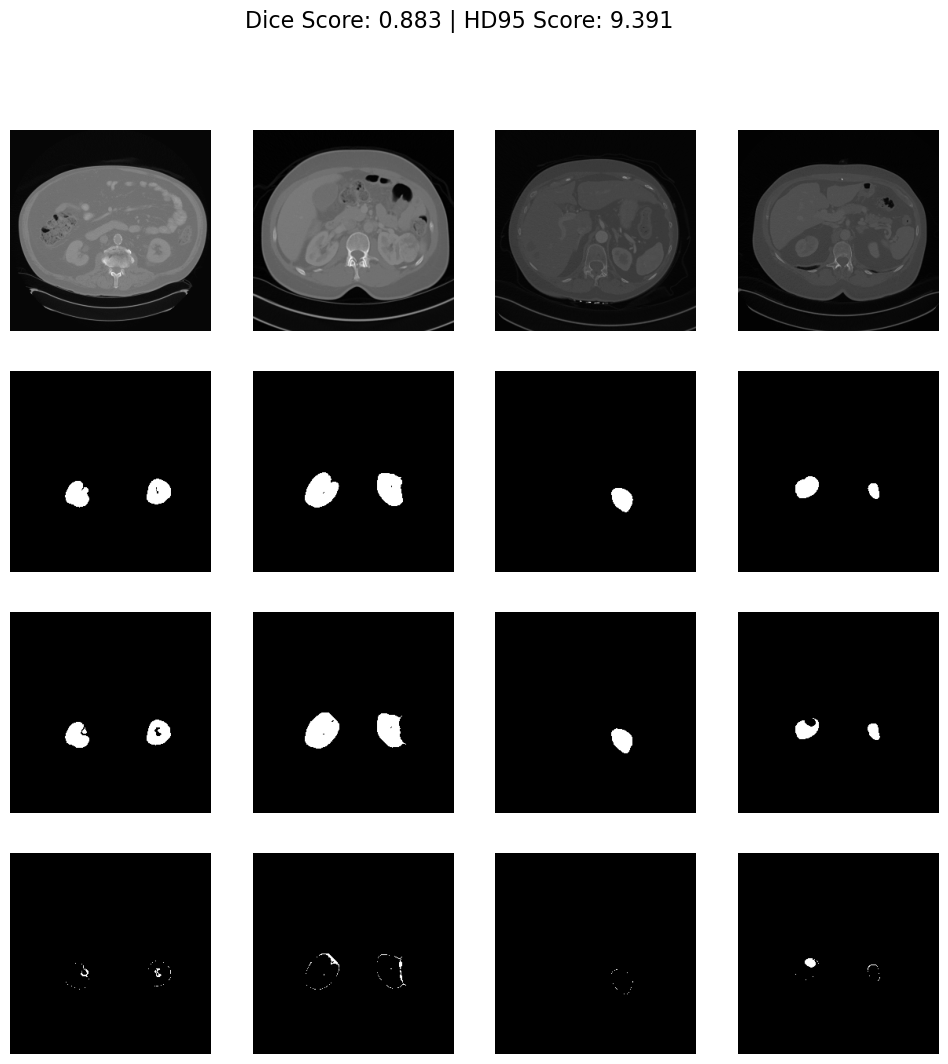

In [34]:
fig, axes = plt.subplots(4, 4, figsize=(12, 12))


for i in range(4):
    # Image slices
    axes[0, i].imshow((input_list[i][0].cpu().detach().numpy())[0, :, :], cmap="gray")
    axes[0, i].axis('off')
    # Predictions by our trained model
    axes[1, i].imshow((inversed_prediction_list[i][0].cpu().detach().numpy())[0, :, :, 16], cmap="gray")
    axes[1, i].axis('off')
    # Ground truth
    axes[2, i].imshow((inversed_targets_list[i][0]['label'].cpu().detach().numpy())[0, :, :, 16], cmap="gray")
    axes[2, i].axis('off')
    # Error maps
    axes[3, i].imshow((inversed_targets_list[i][0]['label'].cpu().detach().numpy())[0, :, :, 16] != (inversed_prediction_list[i][0].cpu().detach().numpy())[0, :, :, 16], cmap="gray")
    axes[3, i].axis('off')
fig.suptitle(f"Dice Score: {final_dice:.3f} | HD95 Score: {final_hd95:.3f}", fontsize=16)
#fig.savefig('predictions_notpretrained3d.png')  
plt.show()